# Random initialization
Created 27/05/2024

Objectives:
* Try random initialization of MPOs and hyperparameters to improve convergence.

# Package imports

In [1]:
import sys

In [2]:
sys.path.append("../../")

In [3]:
from itertools import chain
import re

from collections import Counter, namedtuple

In [4]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [5]:
import numpy as np
from jax import numpy as jnp

import matplotlib.pyplot as plt

import scipy

In [6]:
import quimb as qu
import quimb.tensor as qtn
from quimb.tensor.optimize import TNOptimizer

/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:54: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:36: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:73: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


# Load data

In [7]:
DATA_DIR_1 = r"../../data/interpolated_trivial_to_nontrivial_fermionic_trivial_proj_rep_200_site_dmrg/"
DATA_DIR_2 = r"../../data/interpolated_nontrivial_fermionic_proj_rep_to_nontrivial_proj_rep_200_site_dmrg/"

In [8]:
def parse_file_name(file_name):
    interpolation = int(file_name.split('_')[0])/100

    return interpolation

In [9]:
loaded_data_non_triv_proj_rep = dict()
energies_non_triv_proj_rep = dict()

for local_file_name in list(os.walk(DATA_DIR_2))[0][2]:
    f_name = r"{}/{}".format(DATA_DIR_2, local_file_name, ignore_unknown=False)

    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)

        data_info = parse_file_name(local_file_name)
        loaded_data_non_triv_proj_rep[data_info]=data['wavefunction']
        energies_non_triv_proj_rep[data_info]=data['energy']

In [10]:
psi = loaded_data_non_triv_proj_rep[0]

In [11]:
Counter(
    tuple(psi.get_B(i).get_leg_labels())
    for i in range(psi.L)
)

Counter({('vL', 'p', 'vR'): 200})

In [12]:
psi_arrays = list()
psi_arrays.append(psi.get_B(0, 'Th')[0, ...].to_ndarray())
for i in range(1, psi.L-1):
    psi_arrays.append(psi.get_B(i).to_ndarray())
psi_arrays.append(psi.get_B(psi.L-1)[..., 0].to_ndarray())

In [13]:
q1 = (
    qtn
    .tensor_1d
    .MatrixProductState(
        psi_arrays,
        shape='lpr'
    )
)

# Definitions

## Define tensor network to contract against

In [14]:
np_10 = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

In [15]:
q2 = q1.copy(deep=True)

symmetry_sites = list(range(60, 60+80, 2))
for i in symmetry_sites:

    q2.gate(
        np_10,
        where=i,
        contract=False,
        inplace=True
    )

In [16]:
def generate_problem_rdm(quimb_psi, symmetry_site_pairs, leftmost_symmetry_site,
                         num_symmetry_sites, num_boundary_sites):
    q_top = quimb_psi.copy(deep=True)
    for i, s in symmetry_site_pairs:
        q_top.gate(
            s,
            where=i,
            contract=False,
            inplace=True
        )

    
    indices_to_map = list(chain(
        range(leftmost_symmetry_site-num_boundary_sites, leftmost_symmetry_site),
        range(leftmost_symmetry_site+num_symmetry_sites, leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites)
    ))

    index_mapping = {f'k{i}': f'b{i}' for i in indices_to_map}

    q_bottom = quimb_psi.copy()
    q_bottom.reindex(index_mapping, inplace=True)

    sites_to_contract = {
        'left': list(range(leftmost_symmetry_site-num_boundary_sites)),
        'middle': list(range(leftmost_symmetry_site, leftmost_symmetry_site+num_symmetry_sites)),
        'right': list(range(leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites, quimb_psi.L))
    }

    tags_to_contract = {
        k: [f'I{i}' for i in v]
        for k, v in sites_to_contract.items()
    }

    tn = (q_top & q_bottom)

    tnc = (
        tn
        .contract(tags_to_contract['left'])
        .contract(tags_to_contract['middle'])
        .contract(tags_to_contract['right'])
    )

    return tnc

In [17]:
symmetry_site_pairs = [
    (i, np_10) for i in range(60, 60+80, 2)
]

problem_rdm = generate_problem_rdm(
    q1,
    symmetry_site_pairs,
    60,
    80,
    6
)

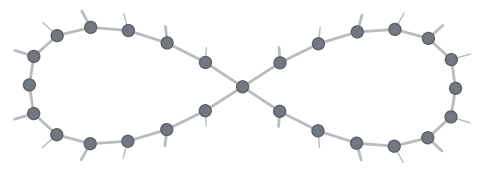

In [18]:
problem_rdm.draw()

## Initialize mpo functions

In [19]:
num_boundary_sites=6
left_most_symmetry_site=60
num_symmetry_sites=80
bond_dimension=6

In [183]:
def initialize_mpo(left_most_symmetry_site, num_symmetry_sites,
                   num_boundary_sites, bond_dimension, phys_dim=[4,2]):
    # Kind of hard coding the physical dimensions.
    ml = qtn.MPO_rand(
        num_boundary_sites,
        bond_dimension,
        phys_dim=phys_dim,
        normalize=True,
        sites=list(range(left_most_symmetry_site-num_boundary_sites, left_most_symmetry_site)),
        dtype=np.complex128,
        tags='left_mpo'
    )

    mr = qtn.MPO_rand(
        num_boundary_sites,
        bond_dimension,
        phys_dim=phys_dim,
        normalize=True,
        sites=list(range(
            left_most_symmetry_site + num_symmetry_sites,
            left_most_symmetry_site + num_symmetry_sites + num_boundary_sites
        )),
        dtype=np.complex128,
        tags='right_mpo'
    )

    mpo = (ml & mr)

    return mpo

## Optimisation functions

In [21]:
def split_mpo_pair(mpo_pair):
    ml = qtn.TensorNetwork(
        list(map(mpo_pair.tensor_map.__getitem__, mpo.tag_map['left_mpo']))
    )

    mr = qtn.TensorNetwork(
        list(map(mpo_pair.tensor_map.__getitem__, mpo.tag_map['right_mpo']))
    )

    return (ml, mr)

In [22]:
def overlap_loss_function(ml, mr, rdm_tn, epsilon=1e-8):
    c = (rdm_tn & ml & mr) ^ ...

    c_abs_squared = (
        c
        *jnp.conjugate(c)
    )
    #c_abs_squared = c_abs_squared.astype('float32')
    c_abs = (jnp.sqrt(c_abs_squared+epsilon))

    target = jnp.sqrt(1+epsilon)
    loss = (c_abs - target)**2

    return loss

In [23]:
def overlap_loss_function_mpo_pair(mpo_pair, rdm_tn):
    ml, mr = split_mpo_pair(mpo_pair)

    return overlap_loss_function(ml, mr, rdm_tn)

In [24]:
total_physical_dim = 2**9

In [25]:
regex_s = r"^I\d+$"
regex_p = re.compile(regex_s)

In [26]:
def relabel_mpo(mpo, k_label, b_label):
    site_locs = [
        int(k[1:]) for k in mpo.tag_map
        if bool(re.search(regex_p, k))
    ]

    k_in_indices = [f'k{i}' for i in site_locs]
    j_in_indices = [f'b{i}' for i in site_locs]

    k_out_indices = [f'{k_label}{i}' for i in site_locs]
    j_out_indices = [f'{b_label}{i}' for i in site_locs]

    mapping = dict(
        chain(
            zip(k_in_indices, k_out_indices),
            zip(j_in_indices, j_out_indices)
        )
    )

    mpo.reindex(mapping, inplace=True)

In [27]:
def unitarity_tn(tn, total_physical_dim):
    ms = [tn.copy(), tn.copy(), tn.copy()]

    relabel_mpo(ms[0], 'k', 'l')
    relabel_mpo(ms[1], 'm', 'l')
    relabel_mpo(ms[2], 'm', 'b')

    ms[0] = ms[0].conj()
    ms[2] = ms[2].conj()

    n2tn = (tn & tn.conj())
    n2 = n2tn.contract(n2tn.tag_map)
    n4tn = (tn & ms[0] & ms[1] & ms[2])
    n4 = n4tn.contract(n4tn.tag_map)

    out = jnp.real(n4 - 2*n2 + total_physical_dim)

    return out

In [28]:
def overall_loss_function(mpo_pair, rdm_tn, total_physical_dimension,
    unitary_cost_coefficient=1, overlap_cost_coefficient=1, losses=None):
    ml, mr = split_mpo_pair(mpo_pair)

    o_loss = overlap_loss_function(ml, mr, rdm_tn)
    ul_loss = jnp.sqrt(1 + unitarity_tn(ml, total_physical_dimension)) - 1
    ur_loss = jnp.sqrt(1 + unitarity_tn(mr, total_physical_dimension)) - 1

    out = (
        unitary_cost_coefficient*(ul_loss+ur_loss)
        + overlap_cost_coefficient*o_loss
    )

    out = jnp.real(out)

    if losses is not None:
        losses.append((o_loss, ul_loss, ur_loss))
    return out

# Runs
## 1

In [38]:
total_physical_dim = 2**9

In [48]:
num_iterations = int(1e4) 
num_seeds = 10

hyperparameter_dists_dict = {
    'alpha': scipy.stats.loguniform(1e-4, 1e-2),
    'beta_1': scipy.stats.uniform(0.1, 0.5),
    'beta_2': scipy.stats.uniform(0.1, 0.5),
    'bond_dimension': scipy.stats.randint(4, 9),
    'overlap_learning_rate': scipy.stats.randint(1, 500)
}

In [49]:
HyperParams = namedtuple('HyperParams', hyperparameter_dists_dict)

In [61]:
optimizers = dict()

for _ in range(num_seeds):
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}

    mpo = initialize_mpo(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        hyperparams['bond_dimension']
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 1,
            'overlap_cost_coefficient': hyperparams['overlap_learning_rate']
        },
        autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='adam',               # supplied to scipy.minimize
    )

    optmzr.optimize(
        num_iterations,
        learning_rate=hyperparams['alpha'],
        beta1=hyperparams['beta_1'],
        beta2=hyperparams['beta_2']
    )

    optimizers[HyperParams(**hyperparams)] = optmzr

  0%|                                                                                                                                                                             | 0/10000 [00:00<?, ?it/s]/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from complex64 to complex128.
  warnings.warn(
+23.943763732910 [best: +23.593446731567] : : 10001it [00:31, 320.68it/s]                                                                                                                                   
+103.656440734863 [best: +103.065574645996] : : 10001it [00:45, 221.60it/s]                                                                             

In [63]:
optimizers

{HyperParams(alpha=0.004409390845252186, beta_1=0.1299432168101656, beta_2=0.3860962851491586, bond_dimension=5, overlap_learning_rate=19): <TNOptimizer(d=4400, backend=jax)>,
 HyperParams(alpha=0.001776906098655119, beta_1=0.4512421805424689, beta_2=0.19152908871261606, bond_dimension=6, overlap_learning_rate=103): <TNOptimizer(d=6240, backend=jax)>,
 HyperParams(alpha=0.00028439677703003674, beta_1=0.29818465227395774, beta_2=0.352768355590086, bond_dimension=5, overlap_learning_rate=129): <TNOptimizer(d=4400, backend=jax)>,
 HyperParams(alpha=0.00023957358195357174, beta_1=0.49861498918785074, beta_2=0.40535083030013885, bond_dimension=7, overlap_learning_rate=135): <TNOptimizer(d=8400, backend=jax)>,
 HyperParams(alpha=0.0013529195769182913, beta_1=0.36217845276271987, beta_2=0.2040280893751997, bond_dimension=4, overlap_learning_rate=456): <TNOptimizer(d=2880, backend=jax)>,
 HyperParams(alpha=0.0009214300425262437, beta_1=0.4559158179775161, beta_2=0.11089258696431539, bond_dimen

In [64]:
optimizer_list = [
    (k, v) for k, v in optimizers.items()
]

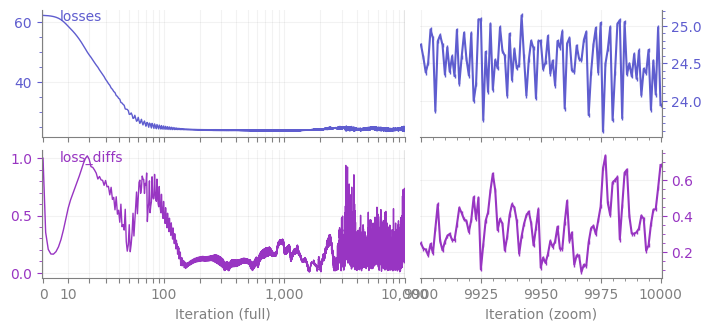

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [65]:
optimizer_list[0][1].plot()

In [66]:
optimizer_list[0][0]

HyperParams(alpha=0.004409390845252186, beta_1=0.1299432168101656, beta_2=0.3860962851491586, bond_dimension=5, overlap_learning_rate=19)

In [69]:
mpo_opt = optimizer_list[0][1].get_tn_opt()
ml, mr = split_mpo_pair(mpo_opt)

In [70]:
(
    overlap_loss_function(ml, mr, problem_rdm),
    unitarity_tn(ml, total_physical_dim),
    unitarity_tn(mr, total_physical_dim),
)

(Array(0.99979997-0.j, dtype=complex64),
 Array(16.952332, dtype=float32, weak_type=True),
 Array(6.3425293, dtype=float32, weak_type=True))

Calculate for each:

In [71]:
final_scores = list()

for h, o in optimizer_list:
    mpo_opt = o.get_tn_opt()
    ml, mr = split_mpo_pair(mpo_opt)

    out = (
        overlap_loss_function(ml, mr, problem_rdm),
        unitarity_tn(ml, total_physical_dim),
        unitarity_tn(mr, total_physical_dim),
    )

    final_scores.append(out)

In [72]:
final_scores

[(Array(0.99979997-0.j, dtype=complex64),
  Array(16.952332, dtype=float32, weak_type=True),
  Array(6.3425293, dtype=float32, weak_type=True)),
 (Array(0.99979997-0.j, dtype=complex64),
  Array(0.85601807, dtype=float32, weak_type=True),
  Array(0.72869873, dtype=float32, weak_type=True)),
 (Array(0.99979997-0.j, dtype=complex64),
  Array(0.03210449, dtype=float32, weak_type=True),
  Array(0.00311279, dtype=float32, weak_type=True)),
 (Array(0.99979997-0.j, dtype=complex64),
  Array(0.00604248, dtype=float32, weak_type=True),
  Array(0.00543213, dtype=float32, weak_type=True)),
 (Array(0.99979997-0.j, dtype=complex64),
  Array(0.08416748, dtype=float32, weak_type=True),
  Array(0.06332397, dtype=float32, weak_type=True)),
 (Array(0.99979997-0.j, dtype=complex64),
  Array(0.70202637, dtype=float32, weak_type=True),
  Array(0.09597778, dtype=float32, weak_type=True)),
 (Array(0.99979997-0.j, dtype=complex64),
  Array(1.6287842, dtype=float32, weak_type=True),
  Array(1.9307861, dtype=fl

In [73]:
x = 1e-8
(jnp.sqrt(1+x)-jnp.sqrt(x))**2

Array(0.99979997, dtype=float32, weak_type=True)

So overlaps are all vanishing...

## 2

In [75]:
def overlap_loss_function(ml, mr, rdm_tn, epsilon=1e-12):
    c = (rdm_tn & ml & mr) ^ ...

    c_abs_squared = (
        c
        *jnp.conjugate(c)
    )
    #c_abs_squared = c_abs_squared.astype('float32')
    c_abs = (jnp.sqrt(c_abs_squared+epsilon))

    target = jnp.sqrt(1+epsilon)
    loss = (c_abs - target)**2

    return loss

In [77]:
num_iterations = int(1e4) 
num_seeds = 5

hyperparameter_dists_dict = {
    'alpha': scipy.stats.loguniform(1e-4, 1e-2),
    'beta_1': scipy.stats.uniform(0.1, 0.5),
    'beta_2': scipy.stats.uniform(0.1, 0.5),
    'bond_dimension': scipy.stats.randint(4, 8),
    'overlap_learning_rate': scipy.stats.randint(100, 500)
}

In [78]:
HyperParams = namedtuple('HyperParams', hyperparameter_dists_dict)

In [79]:
optimizers = dict()

for _ in range(num_seeds):
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}

    mpo = initialize_mpo(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        hyperparams['bond_dimension']
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 1,
            'overlap_cost_coefficient': hyperparams['overlap_learning_rate']
        },
        autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='adam',               # supplied to scipy.minimize
    )

    optmzr.optimize(
        num_iterations,
        learning_rate=hyperparams['alpha'],
        beta1=hyperparams['beta_1'],
        beta2=hyperparams['beta_2']
    )

    optimizers[HyperParams(**hyperparams)] = optmzr

  0%|                                                                                                                                                                             | 0/10000 [00:00<?, ?it/s]/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from complex64 to complex128.
  warnings.warn(
+344.432891845703 [best: +341.532470703125] : : 10001it [00:51, 192.91it/s]                                                                                                                                 
+496.426635742188 [best: +496.003692626953] : : 10001it [00:24, 408.90it/s]                                                                             

In [80]:
optimizers

{HyperParams(alpha=0.004403897437446899, beta_1=0.4782895704421597, beta_2=0.16211894338523639, bond_dimension=7, overlap_learning_rate=341): <TNOptimizer(d=8400, backend=jax)>,
 HyperParams(alpha=0.0011919668254443798, beta_1=0.3952625979596015, beta_2=0.5076223044498013, bond_dimension=4, overlap_learning_rate=496): <TNOptimizer(d=2880, backend=jax)>,
 HyperParams(alpha=0.0010191903626257275, beta_1=0.453477846217464, beta_2=0.3025259116748835, bond_dimension=5, overlap_learning_rate=401): <TNOptimizer(d=4400, backend=jax)>,
 HyperParams(alpha=0.00012615093940193003, beta_1=0.32067092080766857, beta_2=0.5858304377702416, bond_dimension=4, overlap_learning_rate=429): <TNOptimizer(d=2880, backend=jax)>,
 HyperParams(alpha=0.0002823601255244988, beta_1=0.27049137476345664, beta_2=0.4280331904076281, bond_dimension=4, overlap_learning_rate=340): <TNOptimizer(d=2880, backend=jax)>}

In [81]:
optimizer_list = [
    (k, v) for k, v in optimizers.items()
]

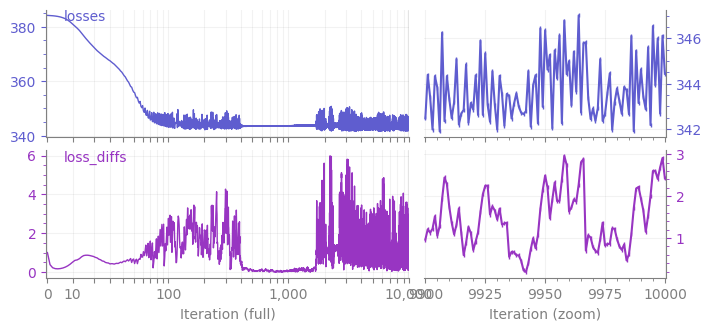

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [82]:
optimizer_list[0][1].plot()

In [83]:
optimizer_list[0][0]

HyperParams(alpha=0.004403897437446899, beta_1=0.4782895704421597, beta_2=0.16211894338523639, bond_dimension=7, overlap_learning_rate=341)

In [84]:
final_scores = list()

for h, o in optimizer_list:
    mpo_opt = o.get_tn_opt()
    ml, mr = split_mpo_pair(mpo_opt)

    out = (
        overlap_loss_function(ml, mr, problem_rdm),
        unitarity_tn(ml, total_physical_dim),
        unitarity_tn(mr, total_physical_dim),
    )

    final_scores.append(out)

In [85]:
final_scores

[(Array(0.999998-0.j, dtype=complex64),
  Array(13.617737, dtype=float32, weak_type=True),
  Array(1.5941162, dtype=float32, weak_type=True)),
 (Array(0.999998-0.j, dtype=complex64),
  Array(0.22296143, dtype=float32, weak_type=True),
  Array(0.7467041, dtype=float32, weak_type=True)),
 (Array(0.999998-0.j, dtype=complex64),
  Array(0.01312256, dtype=float32, weak_type=True),
  Array(0.0145874, dtype=float32, weak_type=True)),
 (Array(0.999998-0.j, dtype=complex64),
  Array(0.00372314, dtype=float32, weak_type=True),
  Array(0.00195312, dtype=float32, weak_type=True)),
 (Array(0.999998-0.j, dtype=complex64),
  Array(0.04589844, dtype=float32, weak_type=True),
  Array(0.01245117, dtype=float32, weak_type=True))]

## 3
Try with just overlaps, there's something weird happening...

In [86]:
def overlap_loss_function(ml, mr, rdm_tn, epsilon=1e-12):
    c = (rdm_tn & ml & mr) ^ ...

    c_abs_squared = (
        c
        *jnp.conjugate(c)
    )
    #c_abs_squared = c_abs_squared.astype('float32')
    c_abs = (jnp.sqrt(c_abs_squared+epsilon))

    target = jnp.sqrt(1+epsilon)
    loss = (c_abs - target)**2

    return loss

In [87]:
num_iterations = int(1e4) 
num_seeds = 5

hyperparameter_dists_dict = {
    'alpha': scipy.stats.loguniform(1e-4, 1e-2),
    'beta_1': scipy.stats.uniform(0.1, 0.5),
    'beta_2': scipy.stats.uniform(0.1, 0.5),
    'bond_dimension': scipy.stats.randint(4, 8),
    'overlap_learning_rate': scipy.stats.randint(100, 500)
}

In [88]:
HyperParams = namedtuple('HyperParams', hyperparameter_dists_dict)

In [89]:
optimizers = dict()

for _ in range(num_seeds):
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}

    mpo = initialize_mpo(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        hyperparams['bond_dimension']
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 0,
            'overlap_cost_coefficient': hyperparams['overlap_learning_rate']
        },
        autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='adam',               # supplied to scipy.minimize
    )

    optmzr.optimize(
        num_iterations,
        learning_rate=hyperparams['alpha'],
        beta1=hyperparams['beta_1'],
        beta2=hyperparams['beta_2']
    )

    optimizers[HyperParams(**hyperparams)] = optmzr

  0%|                                                                                                                                                                             | 0/10000 [00:00<?, ?it/s]/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from complex64 to complex128.
  warnings.warn(
+224.999542236328 [best: +224.999542236328] :   0%|                                                                                                                     | 1/10000 [00:01<3:26:55,  1.24s/it]


In [90]:
optimizers

{HyperParams(alpha=0.00011070820209401891, beta_1=0.33391562586083523, beta_2=0.5137357793053281, bond_dimension=6, overlap_learning_rate=350): <TNOptimizer(d=6240, backend=jax)>,
 HyperParams(alpha=0.000442102982090293, beta_1=0.31718853690311755, beta_2=0.35911074680668253, bond_dimension=7, overlap_learning_rate=229): <TNOptimizer(d=8400, backend=jax)>,
 HyperParams(alpha=0.00047057030919815933, beta_1=0.1642098250909185, beta_2=0.34854868823306917, bond_dimension=5, overlap_learning_rate=117): <TNOptimizer(d=4400, backend=jax)>,
 HyperParams(alpha=0.0019026598377458852, beta_1=0.1177822767156462, beta_2=0.4161044004697708, bond_dimension=6, overlap_learning_rate=255): <TNOptimizer(d=6240, backend=jax)>,
 HyperParams(alpha=0.00012385261782772792, beta_1=0.3019353054769133, beta_2=0.12818859875487468, bond_dimension=7, overlap_learning_rate=225): <TNOptimizer(d=8400, backend=jax)>}

In [91]:
optimizer_list = [
    (k, v) for k, v in optimizers.items()
]

In [93]:
optimizer_list[0][0]

HyperParams(alpha=0.00011070820209401891, beta_1=0.33391562586083523, beta_2=0.5137357793053281, bond_dimension=6, overlap_learning_rate=350)

In [94]:
final_scores = list()

for h, o in optimizer_list:
    mpo_opt = o.get_tn_opt()
    ml, mr = split_mpo_pair(mpo_opt)

    out = (
        overlap_loss_function(ml, mr, problem_rdm),
        unitarity_tn(ml, total_physical_dim),
        unitarity_tn(mr, total_physical_dim),
    )

    final_scores.append(out)

In [95]:
final_scores

[(Array(0.999998-0.j, dtype=complex64),
  Array(510.00674, dtype=float32, weak_type=True),
  Array(510.0076, dtype=float32, weak_type=True)),
 (Array(0.999998-0.j, dtype=complex64),
  Array(510.0067, dtype=float32, weak_type=True),
  Array(510.00742, dtype=float32, weak_type=True)),
 (Array(0.999998-0.j, dtype=complex64),
  Array(510.01022, dtype=float32, weak_type=True),
  Array(510.0098, dtype=float32, weak_type=True)),
 (Array(0.999998-0.j, dtype=complex64),
  Array(510.00766, dtype=float32, weak_type=True),
  Array(510.00763, dtype=float32, weak_type=True)),
 (Array(0.999998-0.j, dtype=complex64),
  Array(510.0066, dtype=float32, weak_type=True),
  Array(510.00708, dtype=float32, weak_type=True))]

## 4 - rms prop

In [97]:
def overlap_loss_function(ml, mr, rdm_tn, epsilon=1e-12):
    c = (rdm_tn & ml & mr) ^ ...

    c_abs_squared = (
        c
        *jnp.conjugate(c)
    )
    #c_abs_squared = c_abs_squared.astype('float32')
    c_abs = (jnp.sqrt(c_abs_squared+epsilon))

    target = jnp.sqrt(1+epsilon)
    loss = (c_abs - target)**2

    return loss

In [99]:
num_iterations = int(1e4) 
num_seeds = 5
bond_dimension=5

In [100]:
optimizers = list()

for _ in range(num_seeds):

    mpo = initialize_mpo(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        bond_dimension
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 0,
            'overlap_cost_coefficient': 1
        },
        autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='rmsprop',               # supplied to scipy.minimize
    )

    optmzr.optimize(
        num_iterations,
        #learning_rate=hyperparams['alpha'],
        #beta1=hyperparams['beta_1'],
        #beta2=hyperparams['beta_2']
    )

    optimizers.append(optmzr)

  0%|                                                                                                                                                                             | 0/10000 [00:00<?, ?it/s]/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from complex64 to complex128.
  warnings.warn(
+0.999997973442 [best: +0.999997973442] :   0%|                                                                                                                         | 1/10000 [00:01<2:47:35,  1.01s/it]


In [101]:
optimizers

[<TNOptimizer(d=4400, backend=jax)>,
 <TNOptimizer(d=4400, backend=jax)>,
 <TNOptimizer(d=4400, backend=jax)>,
 <TNOptimizer(d=4400, backend=jax)>,
 <TNOptimizer(d=4400, backend=jax)>]

In [103]:
final_scores = list()

for o in optimizers:
    mpo_opt = o.get_tn_opt()
    ml, mr = split_mpo_pair(mpo_opt)

    out = (
        overlap_loss_function(ml, mr, problem_rdm),
        unitarity_tn(ml, total_physical_dim),
        unitarity_tn(mr, total_physical_dim),
    )

    final_scores.append(out)

In [104]:
final_scores

[(Array(0.999998-0.j, dtype=complex64),
  Array(510.00925, dtype=float32, weak_type=True),
  Array(510.00864, dtype=float32, weak_type=True)),
 (Array(0.999998-0.j, dtype=complex64),
  Array(510.00885, dtype=float32, weak_type=True),
  Array(510.0087, dtype=float32, weak_type=True)),
 (Array(0.999998-0.j, dtype=complex64),
  Array(510.00803, dtype=float32, weak_type=True),
  Array(510.00854, dtype=float32, weak_type=True)),
 (Array(0.999998-0.j, dtype=complex64),
  Array(510.0079, dtype=float32, weak_type=True),
  Array(510.0076, dtype=float32, weak_type=True)),
 (Array(0.999998-0.j, dtype=complex64),
  Array(510.01215, dtype=float32, weak_type=True),
  Array(510.00854, dtype=float32, weak_type=True))]

## 5 - bosonic case

In [60]:
DATA_DIR_B = r"../../data/transverse_cluster_200_site_dmrg"

In [61]:
loaded_data_b = list()

for local_file_name in os.listdir(DATA_DIR_B):
    f_name = r"{}/{}".format(DATA_DIR_B, local_file_name, ignore_unknown=False)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)
        loaded_data_b.append(data)

In [62]:
b_parameters = sorted(list(d['paramters']['B'] for d in loaded_data_b))

In [63]:
psi_dict_b = dict()

In [64]:
for b in b_parameters:
    psi = next(
        d['wavefunction']
        for d in loaded_data_b
        if d['paramters']['B'] == b
    )

    rounded_b = round(b, 1)
    psi_dict_b[rounded_b] = psi

In [65]:
psi_b = psi_dict_b[0]

In [66]:
Counter(
    tuple(psi.get_B(i).get_leg_labels())
    for i in range(psi.L)
)

Counter({('vL', 'p', 'vR'): 200})

In [67]:
psi_arrays_b = list()
psi_arrays_b.append(psi_b.get_B(0, 'Th')[0, ...].to_ndarray())
for i in range(1, psi_b.L-1):
    psi_arrays_b.append(psi_b.get_B(i).to_ndarray())
psi_arrays_b.append(psi_b.get_B(psi.L-1)[..., 0].to_ndarray())

In [68]:
np_X = np.array([[0,1],[1,0]])

In [69]:
q_b = (
    qtn
    .tensor_1d
    .MatrixProductState(
        psi_arrays_b,
        shape='lpr'
    )
)

In [70]:
q_b

MatrixProductState(tensors=200, indices=399, L=200, max_bond=2)

In [71]:
symmetry_site_pairs = [
    (i, np_X) for i in range(50, 50+100, 2)
]

problem_rdm_b = generate_problem_rdm(
    q_b,
    symmetry_site_pairs,
    50,
    100,
    3
)

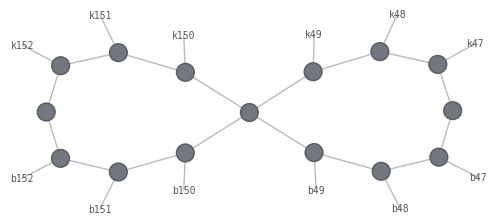

In [72]:
problem_rdm_b.draw()

In [73]:
total_physical_dim=8

In [74]:
num_boundary_sites=3
left_most_symmetry_site=50
num_symmetry_sites=100

In [75]:
num_iterations = int(1e4) 
num_seeds = 5
bond_dimension=5

In [76]:
optimizers = list()

for _ in range(num_seeds):

    mpo = initialize_mpo(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        bond_dimension,
        phys_dim=2
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm_b,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 1,
            'overlap_cost_coefficient': 1
        },
        autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='adam',               # supplied to scipy.minimize
    )

    optmzr.optimize(
        num_iterations,
        #learning_rate=hyperparams['alpha'],
        #beta1=hyperparams['beta_1'],
        #beta2=hyperparams['beta_2']
    )

    optimizers.append(optmzr)

  0%|                                                                                                                                                                             | 0/10000 [00:00<?, ?it/s]/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from complex64 to complex128.
  warnings.warn(
+0.000061764957 [best: +0.000059939692] :  30%|███████████████████████████████████▏                                                                                  | 2977/10000 [00:02<00:04, 1439.52it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, s

In [77]:
optimizers

[<TNOptimizer(d=560, backend=jax)>,
 <TNOptimizer(d=560, backend=jax)>,
 <TNOptimizer(d=560, backend=jax)>,
 <TNOptimizer(d=560, backend=jax)>,
 <TNOptimizer(d=560, backend=jax)>]

In [78]:
final_scores = list()

for o in optimizers:
    mpo_opt = o.get_tn_opt()
    ml, mr = split_mpo_pair(mpo_opt)

    out = (
        overlap_loss_function(ml, mr, problem_rdm_b),
        unitarity_tn(ml, total_physical_dim),
        unitarity_tn(mr, total_physical_dim),
    )

    final_scores.append(out)

In [79]:
final_scores

[(Array(1.6160711e-06+1.4970505e-13j, dtype=complex64),
  Array(0., dtype=float32, weak_type=True),
  Array(0., dtype=float32, weak_type=True)),
 (Array(7.8176595e-07+6.492005e-12j, dtype=complex64),
  Array(1.9073486e-06, dtype=float32, weak_type=True),
  Array(0., dtype=float32, weak_type=True)),
 (Array(6.5459983e-07-1.0333688e-12j, dtype=complex64),
  Array(0., dtype=float32, weak_type=True),
  Array(9.536743e-07, dtype=float32, weak_type=True)),
 (Array(2.2004407e-07-3.949774e-13j, dtype=complex64),
  Array(1.5258789e-05, dtype=float32, weak_type=True),
  Array(1.335144e-05, dtype=float32, weak_type=True)),
 (Array(5.642079e-07-9.538035e-12j, dtype=complex64),
  Array(0., dtype=float32, weak_type=True),
  Array(-9.536743e-07, dtype=float32, weak_type=True))]

All working.

## 6 - Autograd autodiff_backend

In [53]:
from autograd import numpy as anp

In [62]:
def overlap_loss_function(ml, mr, rdm_tn, epsilon=1e-12):
    c = (rdm_tn & ml & mr) ^ ...

    c_abs_squared = (
        c
        *anp.conjugate(c)
    )
    #c_abs_squared = c_abs_squared.astype('float32')
    c_abs = (anp.sqrt(c_abs_squared+epsilon))

    target = anp.sqrt(1+epsilon)
    loss = (c_abs - target)**2

    return loss

In [63]:
total_physical_dim = 2**9

In [64]:
def unitarity_tn(tn, total_physical_dim):
    ms = [tn.copy(), tn.copy(), tn.copy()]

    relabel_mpo(ms[0], 'k', 'l')
    relabel_mpo(ms[1], 'm', 'l')
    relabel_mpo(ms[2], 'm', 'b')

    ms[0] = ms[0].conj()
    ms[2] = ms[2].conj()

    n2tn = (tn & tn.conj())
    n2 = n2tn.contract(n2tn.tag_map)
    n4tn = (tn & ms[0] & ms[1] & ms[2])
    n4 = n4tn.contract(n4tn.tag_map)

    out = np.real(n4 - 2*n2 + total_physical_dim)

    return out

In [65]:
def overall_loss_function(mpo_pair, rdm_tn, total_physical_dimension,
    unitary_cost_coefficient=1, overlap_cost_coefficient=1, losses=None):
    ml, mr = split_mpo_pair(mpo_pair)

    o_loss = overlap_loss_function(ml, mr, rdm_tn)
    ul_loss = anp.sqrt(1 + unitarity_tn(ml, total_physical_dimension)) - 1
    ur_loss = anp.sqrt(1 + unitarity_tn(mr, total_physical_dimension)) - 1

    out = (
        unitary_cost_coefficient*(ul_loss+ur_loss)
        + overlap_cost_coefficient*o_loss
    )

    out = anp.real(out)

    if losses is not None:
        losses.append((o_loss, ul_loss, ur_loss))
    return out

In [66]:
num_iterations = int(1e4) 
num_seeds = 5

hyperparameter_dists_dict = {
    'alpha': scipy.stats.loguniform(1e-4, 1e-2),
    'beta_1': scipy.stats.uniform(0.1, 0.5),
    'beta_2': scipy.stats.uniform(0.1, 0.5),
    'bond_dimension': scipy.stats.randint(4, 8),
    'overlap_learning_rate': scipy.stats.randint(100, 500)
}

In [67]:
HyperParams = namedtuple('HyperParams', hyperparameter_dists_dict)

In [68]:
left_most_symmetry_site=60
num_symmetry_sites=80
num_boundary_sites=6

In [69]:
optimizers = dict()

for _ in range(num_seeds):
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}

    mpo = initialize_mpo(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        hyperparams['bond_dimension']
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 0,
            'overlap_cost_coefficient': hyperparams['overlap_learning_rate']
        },
        autodiff_backend='autograd',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='adam',               # supplied to scipy.minimize
    )

    optmzr.optimize(
        num_iterations,
        learning_rate=hyperparams['alpha'],
        beta1=hyperparams['beta_1'],
        beta2=hyperparams['beta_2']
    )

    optimizers[HyperParams(**hyperparams)] = optmzr

+131.999736000264 [best: +131.999736000264] :   0%|                                                                                                                     | 1/10000 [00:00<1:00:21,  2.76it/s]


In [70]:
optimizers

{HyperParams(alpha=0.0017060412521306275, beta_1=0.22031868015247133, beta_2=0.5901063532634286, bond_dimension=5, overlap_learning_rate=422): <TNOptimizer(d=4400, backend=autograd)>,
 HyperParams(alpha=0.00023638644478081813, beta_1=0.13859299113623705, beta_2=0.11737805327128806, bond_dimension=5, overlap_learning_rate=174): <TNOptimizer(d=4400, backend=autograd)>,
 HyperParams(alpha=0.00022630121020948, beta_1=0.49212233246782466, beta_2=0.14764035842355075, bond_dimension=4, overlap_learning_rate=286): <TNOptimizer(d=2880, backend=autograd)>,
 HyperParams(alpha=0.0012005437017943146, beta_1=0.2833748967804979, beta_2=0.5152836508115556, bond_dimension=7, overlap_learning_rate=164): <TNOptimizer(d=8400, backend=autograd)>,
 HyperParams(alpha=0.0009105695990958645, beta_1=0.46273982360671795, beta_2=0.4211699052961636, bond_dimension=4, overlap_learning_rate=132): <TNOptimizer(d=2880, backend=autograd)>}

In [71]:
optimizer_list = [
    (k, v) for k, v in optimizers.items()
]

In [72]:
optimizer_list[0][0]

HyperParams(alpha=0.0017060412521306275, beta_1=0.22031868015247133, beta_2=0.5901063532634286, bond_dimension=5, overlap_learning_rate=422)

In [73]:
final_scores = list()

for h, o in optimizer_list:
    mpo_opt = o.get_tn_opt()
    ml, mr = split_mpo_pair(mpo_opt)

    out = (
        overlap_loss_function(ml, mr, problem_rdm),
        unitarity_tn(ml, total_physical_dim),
        unitarity_tn(mr, total_physical_dim),
    )

    final_scores.append(out)

In [74]:
final_scores

[((0.999998000002-0j), 510.0071531650075, 510.0090933623008),
 ((0.999998000002-0j), 510.00832602054186, 510.0101030820422),
 ((0.999998000002-0j), 510.01029073624017, 510.0098027884357),
 ((0.999998000002-0j), 510.00818112155855, 510.007877011304),
 ((0.999998000002-0j), 510.01140132816886, 510.0089316395967)]

No change.

## 7 - Autograd tensorflow backend

In [75]:
def overlap_loss_function(ml, mr, rdm_tn, epsilon=1e-12):
    c = (rdm_tn & ml & mr) ^ ...

    c_abs_squared = (
        c
        *np.conjugate(c)
    )
    #c_abs_squared = c_abs_squared.astype('float32')
    c_abs = (np.sqrt(c_abs_squared+epsilon))

    target = np.sqrt(1+epsilon)
    loss = (c_abs - target)**2

    return loss

In [76]:
total_physical_dim = 2**9

In [77]:
def unitarity_tn(tn, total_physical_dim):
    ms = [tn.copy(), tn.copy(), tn.copy()]

    relabel_mpo(ms[0], 'k', 'l')
    relabel_mpo(ms[1], 'm', 'l')
    relabel_mpo(ms[2], 'm', 'b')

    ms[0] = ms[0].conj()
    ms[2] = ms[2].conj()

    n2tn = (tn & tn.conj())
    n2 = n2tn.contract(n2tn.tag_map)
    n4tn = (tn & ms[0] & ms[1] & ms[2])
    n4 = n4tn.contract(n4tn.tag_map)

    out = np.real(n4 - 2*n2 + total_physical_dim)

    return out

In [78]:
def overall_loss_function(mpo_pair, rdm_tn, total_physical_dimension,
    unitary_cost_coefficient=1, overlap_cost_coefficient=1, losses=None):
    ml, mr = split_mpo_pair(mpo_pair)

    o_loss = overlap_loss_function(ml, mr, rdm_tn)
    ul_loss = np.sqrt(1 + unitarity_tn(ml, total_physical_dimension)) - 1
    ur_loss = np.sqrt(1 + unitarity_tn(mr, total_physical_dimension)) - 1

    out = (
        unitary_cost_coefficient*(ul_loss+ur_loss)
        + overlap_cost_coefficient*o_loss
    )

    out = np.real(out)

    if losses is not None:
        losses.append((o_loss, ul_loss, ur_loss))
    return out

In [79]:
num_iterations = int(1e4) 
num_seeds = 5

hyperparameter_dists_dict = {
    'alpha': scipy.stats.loguniform(1e-4, 1e-2),
    'beta_1': scipy.stats.uniform(0.1, 0.5),
    'beta_2': scipy.stats.uniform(0.1, 0.5),
    'bond_dimension': scipy.stats.randint(4, 8),
    'overlap_learning_rate': scipy.stats.randint(100, 500)
}

In [80]:
HyperParams = namedtuple('HyperParams', hyperparameter_dists_dict)

In [81]:
left_most_symmetry_site=60
num_symmetry_sites=80
num_boundary_sites=6

In [83]:
optimizers = dict()

for _ in range(num_seeds):
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}

    mpo = initialize_mpo(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        hyperparams['bond_dimension']
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 0,
            'overlap_cost_coefficient': hyperparams['overlap_learning_rate']
        },
        autodiff_backend='tensorflow',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='adam',               # supplied to scipy.minimize
    )

    optmzr.optimize(
        num_iterations,
        learning_rate=hyperparams['alpha'],
        beta1=hyperparams['beta_1'],
        beta2=hyperparams['beta_2']
    )

    optimizers[HyperParams(**hyperparams)] = optmzr

  0%|                                                                                                                                                                             | 0/10000 [00:00<?, ?it/s]


AttributeError: 'numpy.float64' object has no attribute '_id'

Can't get to work.

## 8 - Autograd torch backend

In [94]:
import math

In [97]:
z.real

1.0

In [106]:
def overlap_loss_function(ml, mr, rdm_tn, epsilon=1e-12):
    c = (rdm_tn & ml & mr) ^ ...

    c_abs_squared = (
        c
        *c.conjugate()
    )
    c_abs_squared=c_abs_squared.real
    #c_abs_squared = c_abs_squared.astype('float32')
    c_abs = (math.sqrt(c_abs_squared+epsilon))

    target = math.sqrt(1+epsilon)
    loss = (c_abs - target)**2

    return loss

In [107]:
total_physical_dim = 2**9

In [108]:
def unitarity_tn(tn, total_physical_dim):
    ms = [tn.copy(), tn.copy(), tn.copy()]

    relabel_mpo(ms[0], 'k', 'l')
    relabel_mpo(ms[1], 'm', 'l')
    relabel_mpo(ms[2], 'm', 'b')

    ms[0] = ms[0].conj()
    ms[2] = ms[2].conj()

    n2tn = (tn & tn.conj())
    n2 = n2tn.contract(n2tn.tag_map)
    n4tn = (tn & ms[0] & ms[1] & ms[2])
    n4 = n4tn.contract(n4tn.tag_map)

    out = (n4 - 2*n2 + total_physical_dim).real

    return out

In [109]:
def overall_loss_function(mpo_pair, rdm_tn, total_physical_dimension,
    unitary_cost_coefficient=1, overlap_cost_coefficient=1, losses=None):
    ml, mr = split_mpo_pair(mpo_pair)

    o_loss = overlap_loss_function(ml, mr, rdm_tn)
    ul_loss = math.sqrt(1 + unitarity_tn(ml, total_physical_dimension)) - 1
    ur_loss = math.sqrt(1 + unitarity_tn(mr, total_physical_dimension)) - 1

    out = (
        unitary_cost_coefficient*(ul_loss+ur_loss)
        + overlap_cost_coefficient*o_loss
    )

    out = out.real

    if losses is not None:
        losses.append((o_loss, ul_loss, ur_loss))
    return out

In [110]:
num_iterations = int(1e4) 
num_seeds = 5

hyperparameter_dists_dict = {
    'alpha': scipy.stats.loguniform(1e-4, 1e-2),
    'beta_1': scipy.stats.uniform(0.1, 0.5),
    'beta_2': scipy.stats.uniform(0.1, 0.5),
    'bond_dimension': scipy.stats.randint(4, 8),
    'overlap_learning_rate': scipy.stats.randint(100, 500)
}

In [111]:
HyperParams = namedtuple('HyperParams', hyperparameter_dists_dict)

In [112]:
left_most_symmetry_site=60
num_symmetry_sites=80
num_boundary_sites=6

In [113]:
mpo = initialize_mpo(
    left_most_symmetry_site,
    num_symmetry_sites,
    num_boundary_sites,
    hyperparams['bond_dimension']
)

In [114]:
overall_loss_function(
    mpo,
    problem_rdm,
    total_physical_dim
)

44.210920795940616

In [115]:
optimizers = dict()

for _ in range(num_seeds):
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}

    mpo = initialize_mpo(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        hyperparams['bond_dimension']
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 0,
            'overlap_cost_coefficient': hyperparams['overlap_learning_rate']
        },
        autodiff_backend='torch',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='adam',               # supplied to scipy.minimize
    )

    optmzr.optimize(
        num_iterations,
        learning_rate=hyperparams['alpha'],
        beta1=hyperparams['beta_1'],
        beta2=hyperparams['beta_2']
    )

    optimizers[HyperParams(**hyperparams)] = optmzr

  0%|                                                                                                                                                                             | 0/10000 [00:00<?, ?it/s]


TypeError: tensordot(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

Can't get to work.

## 9 - L-BFGS-B

In [117]:
def overlap_loss_function(ml, mr, rdm_tn, epsilon=1e-8):
    c = (rdm_tn & ml & mr) ^ ...

    c_abs_squared = (
        c
        *jnp.conjugate(c)
    )
    c_abs_squared = c_abs_squared.astype('float32')
    c_abs = (jnp.sqrt(c_abs_squared+epsilon))

    target = jnp.sqrt(1+epsilon)
    loss = (c_abs - target)**2

    return loss

In [118]:
total_physical_dim = 2**9

In [119]:
def unitarity_tn(tn, total_physical_dim):
    ms = [tn.copy(), tn.copy(), tn.copy()]

    relabel_mpo(ms[0], 'k', 'l')
    relabel_mpo(ms[1], 'm', 'l')
    relabel_mpo(ms[2], 'm', 'b')

    ms[0] = ms[0].conj()
    ms[2] = ms[2].conj()

    n2tn = (tn & tn.conj())
    n2 = n2tn.contract(n2tn.tag_map)
    n4tn = (tn & ms[0] & ms[1] & ms[2])
    n4 = n4tn.contract(n4tn.tag_map)

    out = jnp.real(n4 - 2*n2 + total_physical_dim)

    return out

In [120]:
def overall_loss_function(mpo_pair, rdm_tn, total_physical_dimension,
    unitary_cost_coefficient=1, overlap_cost_coefficient=1, losses=None):
    ml, mr = split_mpo_pair(mpo_pair)

    o_loss = overlap_loss_function(ml, mr, rdm_tn)
    ul_loss = jnp.sqrt(1 + unitarity_tn(ml, total_physical_dimension)) - 1
    ur_loss = jnp.sqrt(1 + unitarity_tn(mr, total_physical_dimension)) - 1

    out = (
        unitary_cost_coefficient*(ul_loss+ur_loss)
        + overlap_cost_coefficient*o_loss
    )

    out = jnp.real(out)

    if losses is not None:
        losses.append((o_loss, ul_loss, ur_loss))
    return out

In [121]:
num_iterations = int(1e4) 
num_seeds = 5

hyperparameter_dists_dict = {
    'alpha': scipy.stats.loguniform(1e-4, 1e-2),
    'beta_1': scipy.stats.uniform(0.1, 0.5),
    'beta_2': scipy.stats.uniform(0.1, 0.5),
    'bond_dimension': scipy.stats.randint(4, 8),
    'overlap_learning_rate': scipy.stats.randint(100, 500)
}

In [122]:
HyperParams = namedtuple('HyperParams', hyperparameter_dists_dict)

In [124]:
optimizers = dict()

for _ in range(num_seeds):
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}

    mpo = initialize_mpo(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        hyperparams['bond_dimension']
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 0,
            'overlap_cost_coefficient': hyperparams['overlap_learning_rate']
        },
        autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='L-BFGS-B',               # supplied to scipy.minimize
    )

    optmzr.optimize(
        num_iterations
    )

    optimizers[HyperParams(**hyperparams)] = optmzr

+394.920989990234 [best: +394.920989990234] :   0%|                                                                                                                     | 1/10000 [00:00<1:49:32,  1.52it/s]


In [125]:
optimizers

{HyperParams(alpha=0.00017618796030585912, beta_1=0.3756658744680327, beta_2=0.11393847609467803, bond_dimension=7, overlap_learning_rate=267): <TNOptimizer(d=8400, backend=jax)>,
 HyperParams(alpha=0.00036282502473841926, beta_1=0.1562756491896002, beta_2=0.24994966946759292, bond_dimension=7, overlap_learning_rate=262): <TNOptimizer(d=8400, backend=jax)>,
 HyperParams(alpha=0.0013263859168604088, beta_1=0.11871258416811217, beta_2=0.5273279112077588, bond_dimension=4, overlap_learning_rate=481): <TNOptimizer(d=2880, backend=jax)>,
 HyperParams(alpha=0.006823306182935286, beta_1=0.511695450728241, beta_2=0.22141678288455005, bond_dimension=4, overlap_learning_rate=278): <TNOptimizer(d=2880, backend=jax)>,
 HyperParams(alpha=0.007248401236919934, beta_1=0.44875916529665716, beta_2=0.36368886328778294, bond_dimension=6, overlap_learning_rate=395): <TNOptimizer(d=6240, backend=jax)>}

In [126]:
optimizer_list = [
    (k, v) for k, v in optimizers.items()
]

In [127]:
optimizer_list[0][0]

HyperParams(alpha=0.00017618796030585912, beta_1=0.3756658744680327, beta_2=0.11393847609467803, bond_dimension=7, overlap_learning_rate=267)

In [128]:
final_scores = list()

for h, o in optimizer_list:
    mpo_opt = o.get_tn_opt()
    ml, mr = split_mpo_pair(mpo_opt)

    out = (
        overlap_loss_function(ml, mr, problem_rdm),
        unitarity_tn(ml, total_physical_dim),
        unitarity_tn(mr, total_physical_dim),
    )

    final_scores.append(out)

In [129]:
final_scores

[(Array(0.99979997, dtype=float32),
  Array(510.00705, dtype=float32, weak_type=True),
  Array(510.00687, dtype=float32, weak_type=True)),
 (Array(0.99979997, dtype=float32),
  Array(510.0068, dtype=float32, weak_type=True),
  Array(510.00723, dtype=float32, weak_type=True)),
 (Array(0.99979997, dtype=float32),
  Array(510.01245, dtype=float32, weak_type=True),
  Array(510.01108, dtype=float32, weak_type=True)),
 (Array(0.99979997, dtype=float32),
  Array(510.01218, dtype=float32, weak_type=True),
  Array(510.0098, dtype=float32, weak_type=True)),
 (Array(0.99979997, dtype=float32),
  Array(510.00735, dtype=float32, weak_type=True),
  Array(510.0081, dtype=float32, weak_type=True))]

## 10 - zero tolerance

In [144]:
optimizers = dict()

for _ in range(num_seeds):
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}

    mpo = initialize_mpo(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        hyperparams['bond_dimension']
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 0,
            'overlap_cost_coefficient': hyperparams['overlap_learning_rate']
        },
        autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='L-BFGS-B',               # supplied to scipy.minimize
    )

    optmzr.optimize(
        num_iterations,
        gtol=0,
        ftol=0
    )

    optimizers[HyperParams(**hyperparams)] = optmzr

+490.901794433594 [best: +490.901794433594] :   0%|                                                                                                                     | 1/10000 [00:00<1:52:45,  1.48it/s]


## 11 - Vary overlap epsilon

In [146]:
def overall_loss_function(mpo_pair, rdm_tn, total_physical_dimension,
    unitary_cost_coefficient=1, overlap_cost_coefficient=1, epsilon=1e-8,
                          losses=None):
    ml, mr = split_mpo_pair(mpo_pair)

    o_loss = overlap_loss_function(ml, mr, rdm_tn, epsilon=epsilon)
    ul_loss = jnp.sqrt(1 + unitarity_tn(ml, total_physical_dimension)) - 1
    ur_loss = jnp.sqrt(1 + unitarity_tn(mr, total_physical_dimension)) - 1

    out = (
        unitary_cost_coefficient*(ul_loss+ur_loss)
        + overlap_cost_coefficient*o_loss
    )

    out = jnp.real(out)

    if losses is not None:
        losses.append((o_loss, ul_loss, ur_loss))
    return out

In [147]:
optimizers = dict()

for _ in range(num_seeds):
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}

    mpo = initialize_mpo(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        hyperparams['bond_dimension']
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 0,
            'overlap_cost_coefficient': hyperparams['overlap_learning_rate'],
            'epsilon': 0
        },
        autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='L-BFGS-B',               # supplied to scipy.minimize
    )

    optmzr.optimize(
        num_iterations,
        gtol=0,
        ftol=0
    )

    optimizers[HyperParams(**hyperparams)] = optmzr

+nan [best: +424.000000000000] :   0%|▌                                                                                                                                  | 41/10000 [00:00<02:55, 56.61it/s]


In [148]:
optimizers = dict()

for _ in range(num_seeds):
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}

    mpo = initialize_mpo(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        hyperparams['bond_dimension']
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 0,
            'overlap_cost_coefficient': hyperparams['overlap_learning_rate'],
            'epsilon': 1e-30
        },
        autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='L-BFGS-B',               # supplied to scipy.minimize
    )

    optmzr.optimize(
        num_iterations,
        gtol=0,
        ftol=0
    )

    optimizers[HyperParams(**hyperparams)] = optmzr

+227.000000000000 [best: +227.000000000000] :   0%|                                                                                                                     | 1/10000 [00:00<1:53:51,  1.46it/s]


In [149]:
optimizers = dict()

for _ in range(num_seeds):
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}

    mpo = initialize_mpo(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        hyperparams['bond_dimension']
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 0,
            'overlap_cost_coefficient': hyperparams['overlap_learning_rate'],
            'epsilon': 1e-60
        },
        autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='L-BFGS-B',               # supplied to scipy.minimize
    )

    optmzr.optimize(
        num_iterations,
        gtol=0,
        ftol=0
    )

    optimizers[HyperParams(**hyperparams)] = optmzr

+nan [best: +452.000000000000] :   0%|▌                                                                                                                                  | 41/10000 [00:00<03:13, 51.35it/s]


In [150]:
optimizers = dict()

for _ in range(num_seeds):
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}

    mpo = initialize_mpo(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        hyperparams['bond_dimension']
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 0,
            'overlap_cost_coefficient': hyperparams['overlap_learning_rate'],
            'epsilon': 1e-45
        },
        autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='L-BFGS-B',               # supplied to scipy.minimize
    )

    optmzr.optimize(
        num_iterations,
        gtol=0,
        ftol=0
    )

    optimizers[HyperParams(**hyperparams)] = optmzr

+nan [best: +355.000000000000] :   0%|▌                                                                                                                                  | 41/10000 [00:00<03:31, 47.11it/s]


In [157]:
optimizers = dict()

for _ in range(num_seeds):
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}

    mpo = initialize_mpo(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        hyperparams['bond_dimension']
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 0,
            'overlap_cost_coefficient': hyperparams['overlap_learning_rate'],
            'epsilon': 1e-30
        },
        autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='L-BFGS-B',               # supplied to scipy.minimize
    )

    optmzr.optimize(
        num_iterations,
        gtol=0,
        ftol=0
    )

    optimizers[HyperParams(**hyperparams)] = optmzr

+271.000000000000 [best: +271.000000000000] :   0%|                                                                                                                     | 1/10000 [00:00<1:52:04,  1.49it/s]


In [158]:
optimizers = dict()

for _ in range(num_seeds):
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}

    mpo = initialize_mpo(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        hyperparams['bond_dimension']
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 0,
            'overlap_cost_coefficient': hyperparams['overlap_learning_rate'],
            'epsilon': 1e-31
        },
        autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='L-BFGS-B',               # supplied to scipy.minimize
    )

    optmzr.optimize(
        num_iterations,
        gtol=0,
        ftol=0
    )

    optimizers[HyperParams(**hyperparams)] = optmzr

+168.000000000000 [best: +168.000000000000] :   0%|                                                                                                                     | 1/10000 [00:00<1:49:57,  1.52it/s]


In [159]:
optimizers = dict()

for _ in range(num_seeds):
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}

    mpo = initialize_mpo(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        hyperparams['bond_dimension']
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 0,
            'overlap_cost_coefficient': hyperparams['overlap_learning_rate'],
            'epsilon': 1e-32
        },
        autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='L-BFGS-B',               # supplied to scipy.minimize
    )

    optmzr.optimize(
        num_iterations,
        gtol=0,
        ftol=0
    )

    optimizers[HyperParams(**hyperparams)] = optmzr

+395.000000000000 [best: +395.000000000000] :   0%|                                                                                                                     | 1/10000 [00:00<1:47:04,  1.56it/s]


In [160]:

optimizers = dict()

for _ in range(num_seeds):
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}

    mpo = initialize_mpo(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        hyperparams['bond_dimension']
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 0,
            'overlap_cost_coefficient': hyperparams['overlap_learning_rate'],
            'epsilon': 1e-33
        },
        autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='L-BFGS-B',               # supplied to scipy.minimize
    )

    optmzr.optimize(
        num_iterations,
        gtol=0,
        ftol=0
    )

    optimizers[HyperParams(**hyperparams)] = optmzr

+104.000000000000 [best: +104.000000000000] :   0%|                                                                                                                     | 1/10000 [00:01<3:50:50,  1.39s/it]


In [161]:

optimizers = dict()

for _ in range(num_seeds):
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}

    mpo = initialize_mpo(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        hyperparams['bond_dimension']
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 0,
            'overlap_cost_coefficient': hyperparams['overlap_learning_rate'],
            'epsilon': 1e-34
        },
        autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='L-BFGS-B',               # supplied to scipy.minimize
    )

    optmzr.optimize(
        num_iterations,
        gtol=0,
        ftol=0
    )

    optimizers[HyperParams(**hyperparams)] = optmzr

+409.000000000000 [best: +409.000000000000] :   0%|                                                                                                                     | 1/10000 [00:00<1:51:10,  1.50it/s]


In [162]:

optimizers = dict()

for _ in range(num_seeds):
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}

    mpo = initialize_mpo(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        hyperparams['bond_dimension']
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 0,
            'overlap_cost_coefficient': hyperparams['overlap_learning_rate'],
            'epsilon': 1e-35
        },
        autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='L-BFGS-B',               # supplied to scipy.minimize
    )

    optmzr.optimize(
        num_iterations,
        gtol=0,
        ftol=0
    )

    optimizers[HyperParams(**hyperparams)] = optmzr

+185.000000000000 [best: +185.000000000000] :   0%|                                                                                                                     | 1/10000 [00:00<2:11:48,  1.26it/s]


In [163]:

optimizers = dict()

for _ in range(num_seeds):
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}

    mpo = initialize_mpo(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        hyperparams['bond_dimension']
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 0,
            'overlap_cost_coefficient': hyperparams['overlap_learning_rate'],
            'epsilon': 1e-36
        },
        autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='L-BFGS-B',               # supplied to scipy.minimize
    )

    optmzr.optimize(
        num_iterations,
        gtol=0,
        ftol=0
    )

    optimizers[HyperParams(**hyperparams)] = optmzr

+405.000000000000 [best: +405.000000000000] :   0%|                                                                                                                     | 1/10000 [00:00<1:58:50,  1.40it/s]


In [164]:

optimizers = dict()

for _ in range(num_seeds):
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}

    mpo = initialize_mpo(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        hyperparams['bond_dimension']
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 0,
            'overlap_cost_coefficient': hyperparams['overlap_learning_rate'],
            'epsilon': 1e-37
        },
        autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='L-BFGS-B',               # supplied to scipy.minimize
    )

    optmzr.optimize(
        num_iterations,
        gtol=0,
        ftol=0
    )

    optimizers[HyperParams(**hyperparams)] = optmzr

+379.000000000000 [best: +379.000000000000] :   0%|                                                                                                                     | 1/10000 [00:00<1:51:11,  1.50it/s]


In [165]:

optimizers = dict()

for _ in range(num_seeds):
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}

    mpo = initialize_mpo(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        hyperparams['bond_dimension']
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 0,
            'overlap_cost_coefficient': hyperparams['overlap_learning_rate'],
            'epsilon': 1e-38
        },
        autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='L-BFGS-B',               # supplied to scipy.minimize
    )

    optmzr.optimize(
        num_iterations,
        gtol=0,
        ftol=0
    )

    optimizers[HyperParams(**hyperparams)] = optmzr

+nan [best: +478.000000000000] :   0%|▌                                                                                                                                  | 41/10000 [00:00<03:26, 48.29it/s]


In [166]:

optimizers = dict()

for _ in range(num_seeds):
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}

    mpo = initialize_mpo(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        hyperparams['bond_dimension']
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 0,
            'overlap_cost_coefficient': hyperparams['overlap_learning_rate'],
            'epsilon': 1e-37
        },
        autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='L-BFGS-B',               # supplied to scipy.minimize
    )

    optmzr.optimize(
        num_iterations,
        gtol=0,
        ftol=0
    )

    optimizers[HyperParams(**hyperparams)] = optmzr

+368.000000000000 [best: +368.000000000000] :   0%|                                                                                                                     | 1/10000 [00:00<1:40:40,  1.66it/s]


## 12 - Two boundary sites

In [184]:
num_iterations = int(1e4) 
num_seeds = 5

hyperparameter_dists_dict = {
    'alpha': scipy.stats.loguniform(1e-4, 1e-2),
    'beta_1': scipy.stats.uniform(0.1, 0.5),
    'beta_2': scipy.stats.uniform(0.1, 0.5),
    'bond_dimension': scipy.stats.randint(4, 8),
    'overlap_learning_rate': scipy.stats.randint(100, 500)
}

In [185]:
HyperParams = namedtuple('HyperParams', hyperparameter_dists_dict)

In [186]:
num_boundary_sites=2

In [187]:
symmetry_site_pairs = [
    (i, np_10) for i in range(60, 60+80, 2)
]

problem_rdm = generate_problem_rdm(
    q1,
    symmetry_site_pairs,
    60,
    80,
    2
)

In [188]:
total_physical_dim = 2**3

In [189]:
optimizers = dict()

for _ in range(num_seeds):
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}

    mpo = initialize_mpo(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        hyperparams['bond_dimension']
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 0,
            'overlap_cost_coefficient': hyperparams['overlap_learning_rate']
        },
        autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='adam',               # supplied to scipy.minimize
    )

    optmzr.optimize(
        num_iterations,
        learning_rate=hyperparams['alpha'],
        beta1=hyperparams['beta_1'],
        beta2=hyperparams['beta_2']
    )

    optimizers[HyperParams(**hyperparams)] = optmzr

  0%|                                                                                                                                                                             | 0/10000 [00:00<?, ?it/s]/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from complex64 to complex128.
  warnings.warn(
+143.971191406250 [best: +143.971191406250] :   0%|                                                                                                                     | 1/10000 [00:00<1:04:43,  2.57it/s]


In [190]:
optimizers

{HyperParams(alpha=0.00030018990929708085, beta_1=0.16478435075303696, beta_2=0.17195435759839886, bond_dimension=5, overlap_learning_rate=264): <TNOptimizer(d=400, backend=jax)>,
 HyperParams(alpha=0.0024305415644666453, beta_1=0.5737181193790005, beta_2=0.14728441669287654, bond_dimension=4, overlap_learning_rate=443): <TNOptimizer(d=320, backend=jax)>,
 HyperParams(alpha=0.005955741181367942, beta_1=0.46514941275422317, beta_2=0.22160148417090356, bond_dimension=5, overlap_learning_rate=353): <TNOptimizer(d=400, backend=jax)>,
 HyperParams(alpha=0.0052502260310572845, beta_1=0.4375632260827663, beta_2=0.13311149706478229, bond_dimension=7, overlap_learning_rate=424): <TNOptimizer(d=560, backend=jax)>,
 HyperParams(alpha=0.00435967129079147, beta_1=0.5542835625201721, beta_2=0.3064196940367412, bond_dimension=6, overlap_learning_rate=144): <TNOptimizer(d=480, backend=jax)>}

In [191]:
optimizer_list = [
    (k, v) for k, v in optimizers.items()
]

In [192]:
optimizer_list[0][0]

HyperParams(alpha=0.00030018990929708085, beta_1=0.16478435075303696, beta_2=0.17195435759839886, bond_dimension=5, overlap_learning_rate=264)

In [193]:
def overlap(ml, mr, rdm_tn):
    c = (rdm_tn & ml & mr) ^ ...

    c_abs_squared = (
        c
        *jnp.conjugate(c)
    )
    #c_abs_squared = c_abs_squared.astype('float32')
    c_abs = (jnp.sqrt(c_abs_squared))

    return c_abs

In [194]:
final_scores = list()

for h, o in optimizer_list:
    mpo_opt = o.get_tn_opt()
    ml, mr = split_mpo_pair(mpo_opt)

    out = (
        overlap(ml, mr, problem_rdm),
        overlap_loss_function(ml, mr, problem_rdm),
        unitarity_tn(ml, total_physical_dim),
        unitarity_tn(mr, total_physical_dim),
    )

    final_scores.append(out)

In [198]:
type(final_scores[0][0])

jaxlib._jax.ArrayImpl

In [195]:
final_scores

[(Array(0.+0.j, dtype=complex64),
  Array(0.99979997, dtype=float32),
  Array(6.2632885, dtype=float32, weak_type=True),
  Array(6.322463, dtype=float32, weak_type=True)),
 (Array(0.+0.j, dtype=complex64),
  Array(0.99979997, dtype=float32),
  Array(6.2620754, dtype=float32, weak_type=True),
  Array(6.307451, dtype=float32, weak_type=True)),
 (Array(0.+0.j, dtype=complex64),
  Array(0.99979997, dtype=float32),
  Array(6.2887177, dtype=float32, weak_type=True),
  Array(6.2552533, dtype=float32, weak_type=True)),
 (Array(0.+0.j, dtype=complex64),
  Array(0.99979997, dtype=float32),
  Array(6.253701, dtype=float32, weak_type=True),
  Array(6.2316794, dtype=float32, weak_type=True)),
 (Array(0.+0.j, dtype=complex64),
  Array(0.99979997, dtype=float32),
  Array(6.2467966, dtype=float32, weak_type=True),
  Array(6.228338, dtype=float32, weak_type=True))]

## 13 - Adjusted overlap function

In [199]:
def overlap_loss_function(ml, mr, rdm_tn, epsilon=1e-8):
    c = (rdm_tn & ml & mr) ^ ...

    c_abs_squared = (
        (c+epsilon)
        *jnp.conjugate(c+epsilon)
    )
    #c_abs_squared = c_abs_squared.astype('float32')
    c_abs = (jnp.sqrt(jnp.real(c_abs_squared)))

    loss = (c_abs - 1)**2

    return loss

In [200]:
num_iterations = int(1e4) 
num_seeds = 5

hyperparameter_dists_dict = {
    'alpha': scipy.stats.loguniform(1e-4, 1e-2),
    'beta_1': scipy.stats.uniform(0.1, 0.5),
    'beta_2': scipy.stats.uniform(0.1, 0.5),
    'bond_dimension': scipy.stats.randint(4, 8),
    'overlap_learning_rate': scipy.stats.randint(100, 500)
}

In [201]:
HyperParams = namedtuple('HyperParams', hyperparameter_dists_dict)

In [210]:
num_boundary_sites=6

In [211]:
symmetry_site_pairs = [
    (i, np_10) for i in range(60, 60+80, 2)
]

problem_rdm = generate_problem_rdm(
    q1,
    symmetry_site_pairs,
    60,
    80,
    num_boundary_sites
)

In [213]:
total_physical_dim = 2**9

In [215]:
total_physical_dim

512

In [225]:
optimizers = dict()

for _ in range(num_seeds):
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}

    mpo = initialize_mpo(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        hyperparams['bond_dimension']
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 0,
            'overlap_cost_coefficient': hyperparams['overlap_learning_rate'],
            'epsilon': 0.1,
        },
        autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='adam',               # supplied to scipy.minimize
    )

    optmzr.optimize(
        num_iterations,
        learning_rate=hyperparams['alpha'],
        beta1=hyperparams['beta_1'],
        beta2=hyperparams['beta_2']
    )

    optimizers[HyperParams(**hyperparams)] = optmzr

+392.039978027344 [best: +392.039978027344] :   0%|                                                                                                                     | 1/10000 [00:01<2:59:24,  1.08s/it]


In [226]:
optimizers

{HyperParams(alpha=0.0011762460382185882, beta_1=0.10877018853725737, beta_2=0.46454351046543263, bond_dimension=4, overlap_learning_rate=338): <TNOptimizer(d=2880, backend=jax)>,
 HyperParams(alpha=0.0004227819155715689, beta_1=0.5932637719442143, beta_2=0.5883258062338554, bond_dimension=4, overlap_learning_rate=142): <TNOptimizer(d=2880, backend=jax)>,
 HyperParams(alpha=0.0001649955097031031, beta_1=0.10993769016629315, beta_2=0.4890935295827161, bond_dimension=4, overlap_learning_rate=487): <TNOptimizer(d=2880, backend=jax)>,
 HyperParams(alpha=0.000975066604663884, beta_1=0.41331850005743787, beta_2=0.31317806638702195, bond_dimension=4, overlap_learning_rate=368): <TNOptimizer(d=2880, backend=jax)>,
 HyperParams(alpha=0.0006719386965100495, beta_1=0.2306811263867579, beta_2=0.3206162564389441, bond_dimension=4, overlap_learning_rate=484): <TNOptimizer(d=2880, backend=jax)>}

In [227]:
optimizer_list = [
    (k, v) for k, v in optimizers.items()
]

In [228]:
optimizer_list[0][0]

HyperParams(alpha=0.0011762460382185882, beta_1=0.10877018853725737, beta_2=0.46454351046543263, bond_dimension=4, overlap_learning_rate=338)

In [229]:
def overlap(ml, mr, rdm_tn):
    c = (rdm_tn & ml & mr) ^ ...

    c_abs_squared = (
        c
        *jnp.conjugate(c)
    )
    #c_abs_squared = c_abs_squared.astype('float32')
    c_abs = (jnp.sqrt(c_abs_squared))

    return c_abs

In [233]:
final_scores = list()

for h, o in optimizer_list:
    mpo_opt = o.get_tn_opt()
    ml, mr = split_mpo_pair(mpo_opt)

    out = (
        overlap(ml, mr, problem_rdm),
        overlap_loss_function(ml, mr, problem_rdm, epsilon=0.1),
        unitarity_tn(ml, total_physical_dim),
        unitarity_tn(mr, total_physical_dim),
    )

    final_scores.append(out)

In [234]:
type(final_scores[0][0])

jaxlib._jax.ArrayImpl

In [235]:
final_scores

[(Array(0.+0.j, dtype=complex64),
  Array(0.80999994, dtype=float32),
  Array(510.01074, dtype=float32, weak_type=True),
  Array(510.00952, dtype=float32, weak_type=True)),
 (Array(0.+0.j, dtype=complex64),
  Array(0.80999994, dtype=float32),
  Array(510.01108, dtype=float32, weak_type=True),
  Array(510.01236, dtype=float32, weak_type=True)),
 (Array(0.+0.j, dtype=complex64),
  Array(0.80999994, dtype=float32),
  Array(510.01108, dtype=float32, weak_type=True),
  Array(510.01056, dtype=float32, weak_type=True)),
 (Array(0.+0.j, dtype=complex64),
  Array(0.80999994, dtype=float32),
  Array(510.01172, dtype=float32, weak_type=True),
  Array(510.00995, dtype=float32, weak_type=True)),
 (Array(0.+0.j, dtype=complex64),
  Array(0.80999994, dtype=float32),
  Array(510.01038, dtype=float32, weak_type=True),
  Array(510.01193, dtype=float32, weak_type=True))]

# Conclusion
Still not clear what's going on, more work to do.